In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms,datasets

In [ ]:
#Загрузка датасета, нормализирующие пробразования, создание выборок
transform = transforms.Compose([transforms.ToTensor(),
transforms.Normalize((0.0,), (1.0,))])
dataset = datasets.MNIST(root = './data', train=True, transform = transform, download=True)
train_set, val_set = torch.utils.data.random_split(dataset, [50000, 10000])
test_set = datasets.MNIST(root = './data', train=False, transform = transform, download=True)
train_loader = torch.utils.data.DataLoader(train_set,batch_size=1,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set,batch_size=1,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size=1,shuffle=True)
print("Training data:", len(train_loader), "Validation data:", len(val_loader), "Test data:", len(test_loader))

100%|██████████| 9912422/9912422 [00:00<00:00, 151352818.93it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 114386868.58it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27455017.28it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23374881.92it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



Training data: 50000 Validation data: 10000 Test data: 10000


In [ ]:
use_cuda=True
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

In [ ]:
#Создание класса
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

model = Net().to(device)

In [ ]:
#Создание оптимизатора, функции потерь и трейнер
optimizer = optim.Adam(model.parameters(),lr=0.0001, betas=(0.9, 0.999))
criterion = nn.NLLLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
factor=0.1, patience=3)

In [ ]:
#Функция обучения сети
def fit(model, device, train_loader, val_loader, epochs):
    data_loader = {'train': train_loader, 'val': val_loader}
    print("Обучение модели...")
    train_loss, val_loss = [], []
    for epoch in range(epochs):
        loss_per_epoch, val_loss_per_epoch = 0, 0
        for phase in ('train', 'val'):
            for i, data in enumerate(data_loader[phase]):
                input, label = data[0].to(device), data[1].to(device)
                output = model(input)
                loss = criterion(output, label)
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    loss_per_epoch += loss.item()
                else:
                    val_loss_per_epoch += loss.item()
            if phase == 'val':
                scheduler.step(val_loss_per_epoch / len(val_loader))
        print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch + 1, loss_per_epoch / len(train_loader),
                                                       val_loss_per_epoch / len(val_loader)))
        train_loss.append(loss_per_epoch / len(train_loader))
        val_loss.append(val_loss_per_epoch / len(val_loader))
    return train_loss, val_loss

In [ ]:
loss, val_loss = fit(model, device, train_loader, val_loader, 10)

Обучение модели...


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1345: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch: 1 Loss: 0.30169146190065194 Val_Loss: 0.13624116734341374
Epoch: 2 Loss: 0.11385215888366686 Val_Loss: 0.11212735194865295
Epoch: 3 Loss: 0.08931688725539313 Val_Loss: 0.1077569337985218
Epoch: 4 Loss: 0.07647761693995546 Val_Loss: 0.0949444459574684
Epoch: 5 Loss: 0.06608417203363492 Val_Loss: 0.09551440333353525
Epoch: 6 Loss: 0.06405925023769138 Val_Loss: 0.09811758719256641
Epoch: 7 Loss: 0.05868750521209254 Val_Loss: 0.08926086834414591
Epoch: 8 Loss: 0.05589742640573948 Val_Loss: 0.09280121179864256
Epoch: 9 Loss: 0.05432149207686305 Val_Loss: 0.07645693605914583
Epoch: 10 Loss: 0.05454949912530799 Val_Loss: 0.07341230756869553


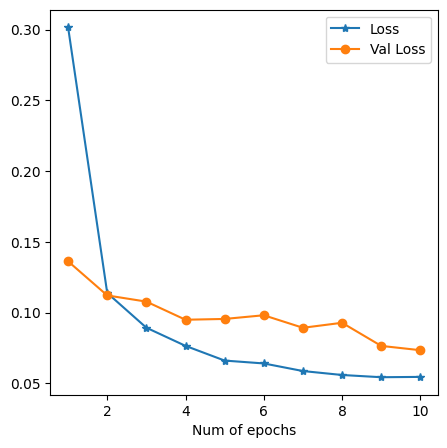

In [ ]:
#Графики потерь и валидации
fig = plt.figure(figsize=(5,5))
plt.plot(np.arange(1,11), loss, "*-",label="Loss")
plt.plot(np.arange(1,11), val_loss,"o-",label="Val Loss")
plt.xlabel("Num of epochs")
plt.legend()
plt.show()

In [ ]:
#Функции атак FGSM, I-FGSM, MI-FGSM
def fgsm_attack(input,epsilon,data_grad):
  pert_out = input + epsilon*data_grad.sign()
  pert_out = torch.clamp(pert_out, 0, 1)
  return pert_out

def ifgsm_attack(input,epsilon,data_grad):
  iter = 10
  alpha = epsilon/iter
  pert_out = input
  for i in range(iter-1):
    pert_out = pert_out + alpha*data_grad.sign()
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out

def mifgsm_attack(input,epsilon,data_grad):
  iter=10
  decay_factor=1.0
  pert_out = input
  alpha = epsilon/iter
  g=0
  for i in range(iter-1):
    g = decay_factor*g + data_grad/torch.norm(data_grad,p=1)
    pert_out = pert_out + alpha*torch.sign(g)
    pert_out = torch.clamp(pert_out, 0, 1)
    if torch.norm((pert_out-input),p=float('inf')) > epsilon:
      break
  return pert_out


In [ ]:
#Проверочная функция
def test(model,device,test_loader,epsilon,attack):
  correct = 0
  adv_examples = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    data.requires_grad = True
    output = model(data)
    init_pred = output.max(1, keepdim=True)[1]
    if init_pred.item() != target.item():
      continue
    loss = F.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data
    if attack == "fgsm":
      perturbed_data = fgsm_attack(data,epsilon,data_grad)
    elif attack == "ifgsm":
      perturbed_data = ifgsm_attack(data,epsilon,data_grad)
    elif attack == "mifgsm":
      perturbed_data = mifgsm_attack(data,epsilon,data_grad)
    output = model(perturbed_data)
    final_pred = output.max(1, keepdim=True)[1]
    if final_pred.item() == target.item():
      correct += 1
    if (epsilon == 0) and (len(adv_examples) < 5):
      adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
      adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
    else:
      if len(adv_examples) < 5:
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc, adv_examples

Epsilon: 0	Test Accuracy = 9697 / 10000 = 0.9697
Epsilon: 0.007	Test Accuracy = 9689 / 10000 = 0.9689
Epsilon: 0.01	Test Accuracy = 9663 / 10000 = 0.9663
Epsilon: 0.02	Test Accuracy = 9638 / 10000 = 0.9638
Epsilon: 0.03	Test Accuracy = 9535 / 10000 = 0.9535
Epsilon: 0.05	Test Accuracy = 9400 / 10000 = 0.94
Epsilon: 0.1	Test Accuracy = 8787 / 10000 = 0.8787
Epsilon: 0.2	Test Accuracy = 6695 / 10000 = 0.6695
Epsilon: 0.3	Test Accuracy = 4873 / 10000 = 0.4873


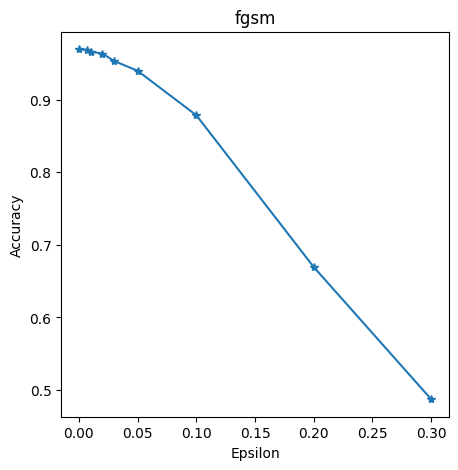

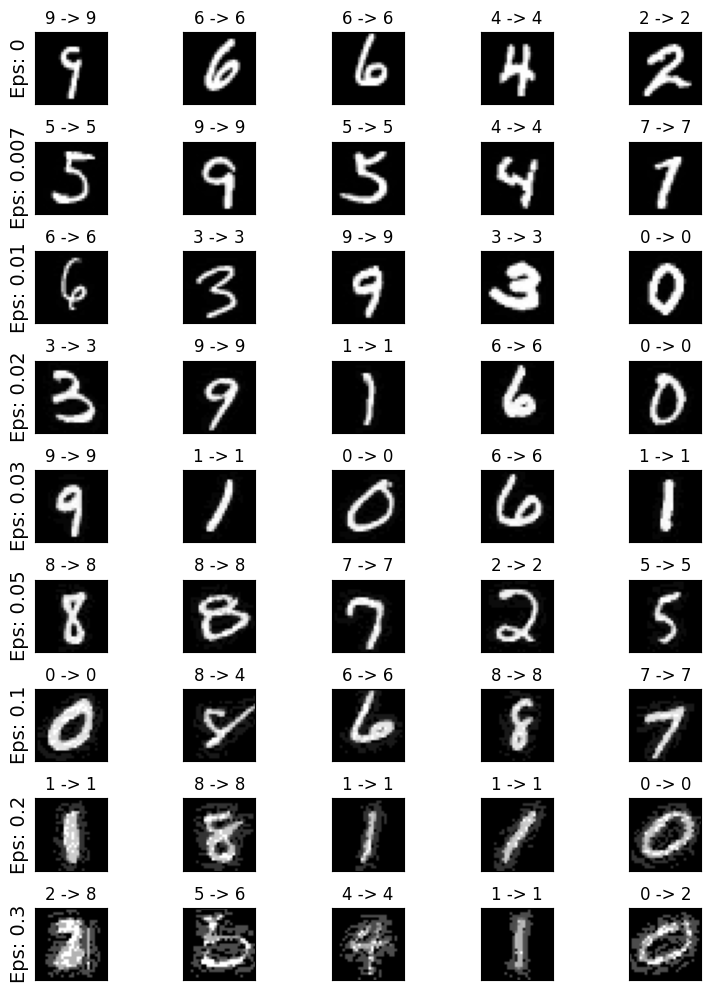

Epsilon: 0	Test Accuracy = 9717 / 10000 = 0.9717
Epsilon: 0.007	Test Accuracy = 9698 / 10000 = 0.9698
Epsilon: 0.01	Test Accuracy = 9673 / 10000 = 0.9673
Epsilon: 0.02	Test Accuracy = 9635 / 10000 = 0.9635
Epsilon: 0.03	Test Accuracy = 9565 / 10000 = 0.9565
Epsilon: 0.05	Test Accuracy = 9473 / 10000 = 0.9473
Epsilon: 0.1	Test Accuracy = 8943 / 10000 = 0.8943
Epsilon: 0.2	Test Accuracy = 7134 / 10000 = 0.7134
Epsilon: 0.3	Test Accuracy = 5339 / 10000 = 0.5339


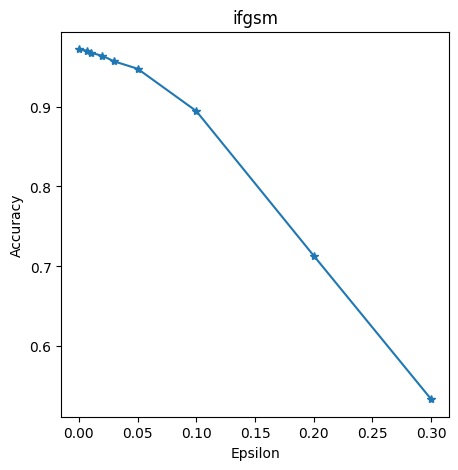

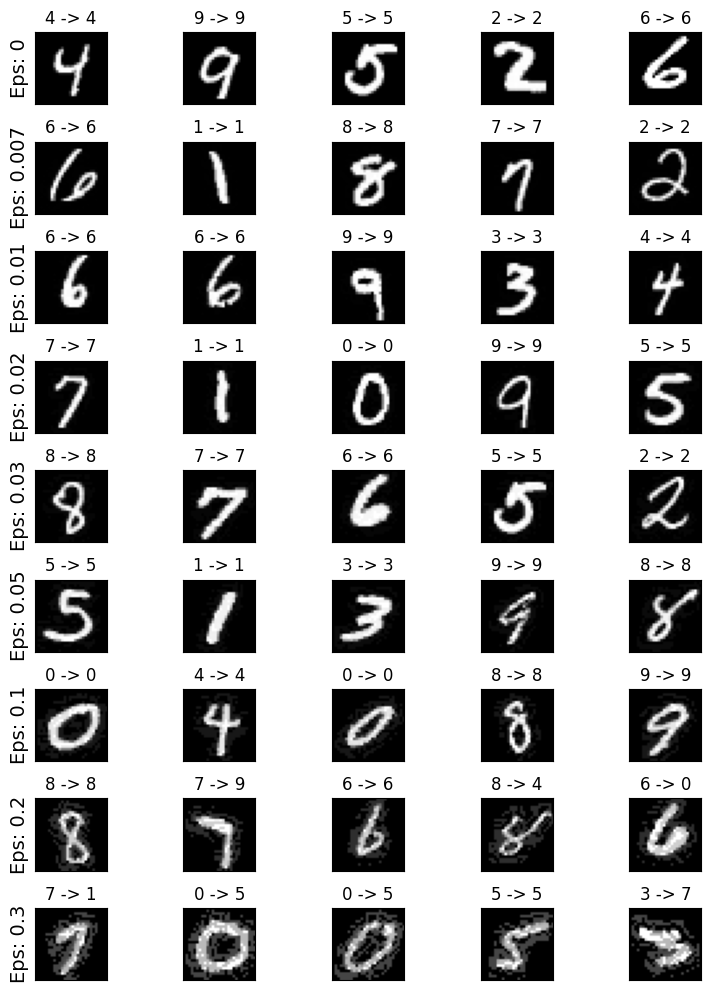

Epsilon: 0	Test Accuracy = 9714 / 10000 = 0.9714
Epsilon: 0.007	Test Accuracy = 9664 / 10000 = 0.9664
Epsilon: 0.01	Test Accuracy = 9667 / 10000 = 0.9667
Epsilon: 0.02	Test Accuracy = 9633 / 10000 = 0.9633
Epsilon: 0.03	Test Accuracy = 9587 / 10000 = 0.9587
Epsilon: 0.05	Test Accuracy = 9454 / 10000 = 0.9454
Epsilon: 0.1	Test Accuracy = 8938 / 10000 = 0.8938
Epsilon: 0.2	Test Accuracy = 7173 / 10000 = 0.7173
Epsilon: 0.3	Test Accuracy = 5368 / 10000 = 0.5368


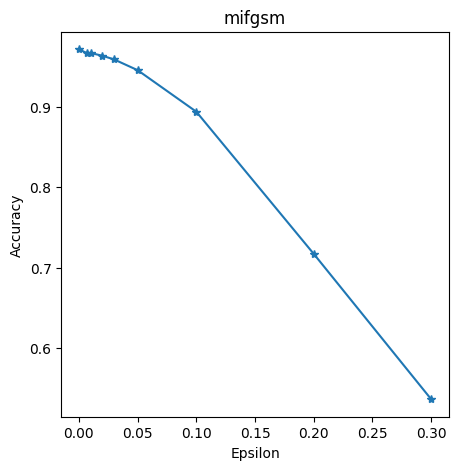

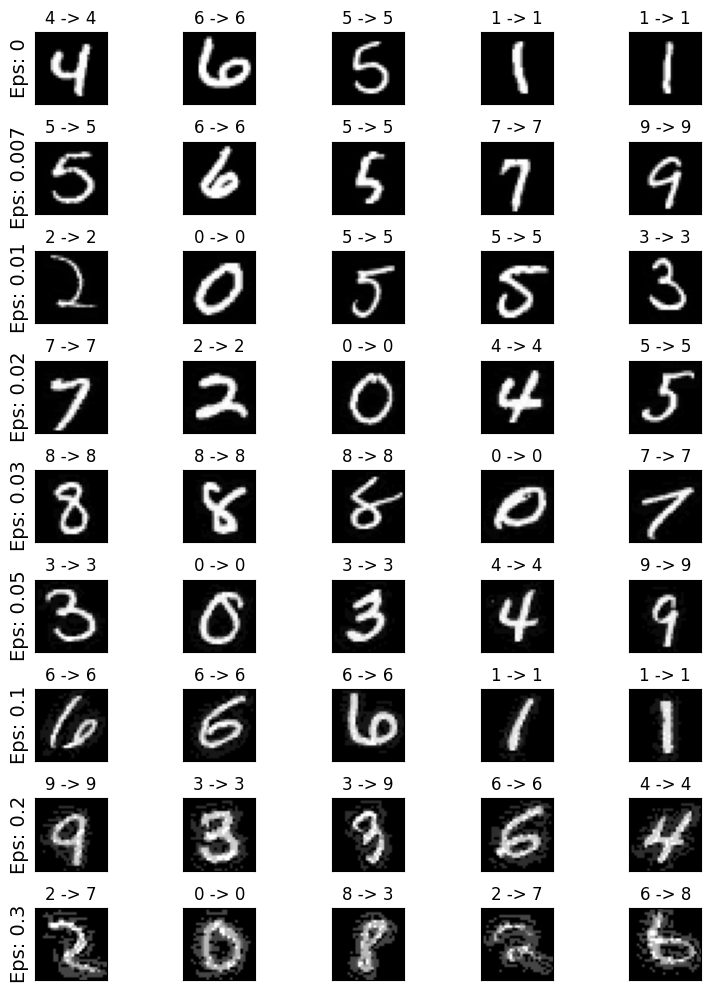

In [ ]:
#Графики успешности атак от eps
epsilons = [0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
for attack in ("fgsm","ifgsm","mifgsm"):
  accuracies = []
  examples = []
  for eps in epsilons:
    acc, ex = test(model, device,test_loader,eps,attack)
    accuracies.append(acc)
    examples.append(ex)
  plt.figure(figsize=(5,5))
  plt.plot(epsilons, accuracies, "*-")
  plt.title(attack)
  plt.xlabel("Epsilon")
  plt.ylabel("Accuracy")
  plt.show()
  cnt = 0
  plt.figure(figsize=(8,10))
  for i in range(len(epsilons)):
    for j in range(len(examples[i])):
      cnt += 1
      plt.subplot(len(epsilons),len(examples[0]),cnt)
      plt.xticks([], [])
      plt.yticks([], [])
      if j == 0:
        plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
      orig,adv,ex = examples[i][j]
      plt.title("{} -> {}".format(orig, adv))
      plt.imshow(ex, cmap="gray")
  plt.tight_layout()
  plt.show()

In [ ]:
#Создание класса
class NetF(nn.Module):
  def __init__(self):
    super(NetF, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, 3, 1)
    self.conv2 = nn.Conv2d(32, 64, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(9216, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

class NetF1(nn.Module):
  def __init__(self):
    super(NetF1, self).__init__()
    self.conv1 = nn.Conv2d(1, 16, 3, 1)
    self.conv2 = nn.Conv2d(16, 32, 3, 1)
    self.dropout1 = nn.Dropout2d(0.25)
    self.dropout2 = nn.Dropout2d(0.5)
    self.fc1 = nn.Linear(4608, 64)
    self.fc2 = nn.Linear(64, 10)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x, 2)
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout2(x)
    x = self.fc2(x)
    return x

In [ ]:
#Функции обучения и тестирования
def fit(model,device,optimizer,scheduler,criterion,train_loader,val_loader,Temp,epochs):
  data_loader = {'train':train_loader,'val':val_loader}
  print("Fitting the model...")
  train_loss,val_loss=[],[]
  for epoch in range(epochs):
    loss_per_epoch,val_loss_per_epoch=0,0
    for phase in ('train','val'):
      for i,data in enumerate(data_loader[phase]):
        input,label = data[0].to(device),data[1].to(device)
        output = model(input)
        output = F.log_softmax(output/Temp,dim=1)
        #calculating loss on the output
        loss = criterion(output,label)
        if phase == 'train':
          optimizer.zero_grad()
          #grad calc w.r.t Loss func
          loss.backward()
          #update weights
          optimizer.step()
          loss_per_epoch+=loss.item()
      else:
        val_loss_per_epoch+=loss.item()
    scheduler.step(val_loss_per_epoch/len(val_loader))
    print("Epoch: {} Loss: {} Val_Loss: {}".format(epoch+1,loss_per_epoch/len(train_loader),val_loss_per_epoch/len(val_loader)))
    train_loss.append(loss_per_epoch/len(train_loader))
    val_loss.append(val_loss_per_epoch/len(val_loader))
  return train_loss,val_loss

  def test(model,device,test_loader,epsilon,Temp,attack):
    correct=0
    adv_examples = []
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      data.requires_grad = True
      output = model(data)
      output = F.log_softmax(output/Temp,dim=1)
      init_pred = output.max(1, keepdim=True)[1]
      if init_pred.item() != target.item():
        continue
      loss = F.nll_loss(output, target)
      model.zero_grad()
      loss.backward()
      data_grad = data.grad.data
      if attack == "fgsm":
        perturbed_data = fgsm_attack(data,epsilon,data_grad)
      elif attack == "ifgsm":
        perturbed_data = ifgsm_attack(data,epsilon,data_grad)
      elif attack == "mifgsm":
        perturbed_data = mifgsm_attack(data,epsilon,data_grad)
      output = model(perturbed_data)
      final_pred = output.max(1, keepdim=True)[1]
      if final_pred.item() == target.item():
        correct += 1
        if (epsilon == 0) and (len(adv_examples) < 5):
          adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
          adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
          if len(adv_examples) < 5:
            adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
            adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
  final_acc = correct/float(len(test_loader))
  print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))
  return final_acc,adv_examples

In [ ]:
#Функция защиты методом дистилляции
def defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons):

  modelF = NetF().to(device)
  optimizerF = optim.Adam(modelF.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF = optim.lr_scheduler.ReduceLROnPlateau(optimizerF, mode='min', factor=0.1, patience=3)

  modelF1 = NetF1().to(device)
  optimizerF1 = optim.Adam(modelF1.parameters(),lr=0.0001, betas=(0.9, 0.999))
  schedulerF1 = optim.lr_scheduler.ReduceLROnPlateau(optimizerF1, mode='min', factor=0.1, patience=3)

  criterion = nn.NLLLoss()

  lossF,val_lossF=fit(modelF,device,optimizerF,schedulerF,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF,"o-",label="Val Loss")
  plt.title("Network F")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  for data in train_loader:
    input, label = data[0].to(device),data[1].to(device)
    softlabel = F.log_softmax(modelF(input),dim=1)
    data[1] = softlabel

  lossF1,val_lossF1=fit(modelF1,device,optimizerF1,schedulerF1,criterion,train_loader,val_loader,Temp,epochs)
  fig = plt.figure(figsize=(5,5))
  plt.plot(np.arange(1,epochs+1), lossF1, "*-",label="Loss")
  plt.plot(np.arange(1,epochs+1), val_lossF1,"o-",label="Val Loss")
  plt.title("Network F'")
  plt.xlabel("Num of epochs")
  plt.legend()
  plt.show()

  model = NetF1().to(device)
  model.load_state_dict(modelF1.state_dict())
  for attack in ("fgsm","ifgsm","mifgsm"):
    accuracies = []
    examples = []
    for eps in epsilons:
      acc, ex = test(model,device,test_loader,eps,attack)
      accuracies.append(acc)
      examples.append(ex)
    plt.figure(figsize=(5,5))
    plt.plot(epsilons, accuracies, "*-")
    plt.title(attack)
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()
    cnt = 0
    plt.figure(figsize=(8,10))
    for i in range(len(epsilons)):
      for j in range(len(examples[i])):
        cnt += 1
        plt.subplot(len(epsilons),len(examples[0]),cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
          plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

Fitting the model...
Epoch: 1 Loss: 0.569490753304214 Val_Loss: 1.4648217242211103e-06
Epoch: 2 Loss: 0.3653854039179934 Val_Loss: 4.113450646400451e-06
Epoch: 3 Loss: 0.28705887340740205 Val_Loss: 3.972511266965739e-07
Epoch: 4 Loss: 0.22016926576014093 Val_Loss: 1.3286041654646396e-05
Epoch: 5 Loss: 0.17866079680688138 Val_Loss: 3.7680921319406478e-06
Epoch: 6 Loss: 0.1475831726622448 Val_Loss: 1.2508082389820174e-05
Epoch: 7 Loss: 0.12857794448598064 Val_Loss: 1.4987458853283896e-07
Epoch: 8 Loss: 0.11672966229551866 Val_Loss: 2.5056331255473198e-05
Epoch: 9 Loss: 0.11049879354905191 Val_Loss: 1.2278484035732618e-09
Epoch: 10 Loss: 0.10426744597065397 Val_Loss: 1.4423406082642032e-08


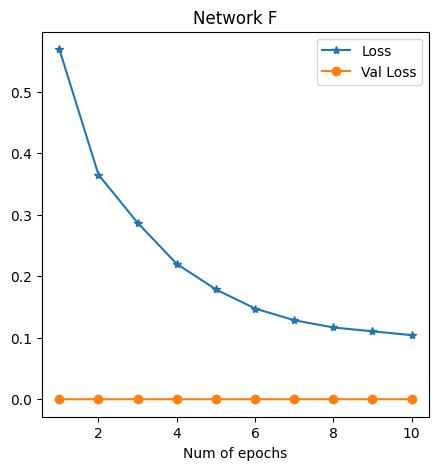

Fitting the model...
Epoch: 1 Loss: 0.7159205913203566 Val_Loss: 1.644612685777247e-06
Epoch: 2 Loss: 0.47303139527268 Val_Loss: 6.454535424709321e-05
Epoch: 3 Loss: 0.4175536345920615 Val_Loss: 2.0400854572653772e-05
Epoch: 4 Loss: 0.3599531813724689 Val_Loss: 1.6662862384691835e-06
Epoch: 5 Loss: 0.3053086478361684 Val_Loss: 8.43973271548748e-05
Epoch: 6 Loss: 0.266633245972485 Val_Loss: 0.00012979022338986397
Epoch: 7 Loss: 0.25778523734622655 Val_Loss: 3.738307626917958e-05
Epoch: 8 Loss: 0.25466580854708304 Val_Loss: 2.1428387612104416e-05
Epoch: 9 Loss: 0.2543274539124935 Val_Loss: 1.2637073121368303e-06
Epoch: 10 Loss: 0.24562370655762036 Val_Loss: 4.0530336264055225e-09


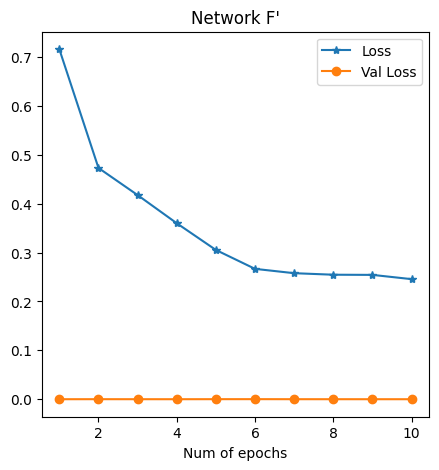

Epsilon: 0	Test Accuracy = 8916 / 10000 = 0.8916
Epsilon: 0.007	Test Accuracy = 8802 / 10000 = 0.8802
Epsilon: 0.01	Test Accuracy = 8765 / 10000 = 0.8765
Epsilon: 0.02	Test Accuracy = 8702 / 10000 = 0.8702
Epsilon: 0.03	Test Accuracy = 8581 / 10000 = 0.8581
Epsilon: 0.05	Test Accuracy = 8279 / 10000 = 0.8279
Epsilon: 0.1	Test Accuracy = 7150 / 10000 = 0.715
Epsilon: 0.2	Test Accuracy = 3244 / 10000 = 0.3244
Epsilon: 0.3	Test Accuracy = 958 / 10000 = 0.0958


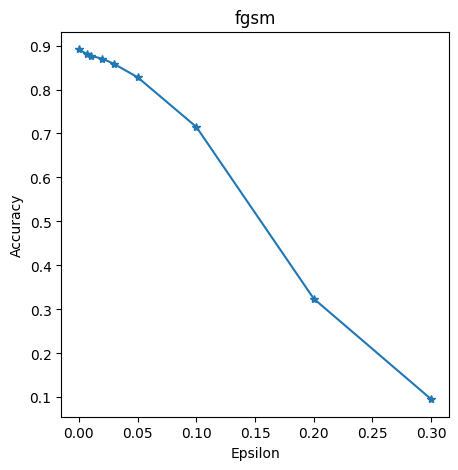

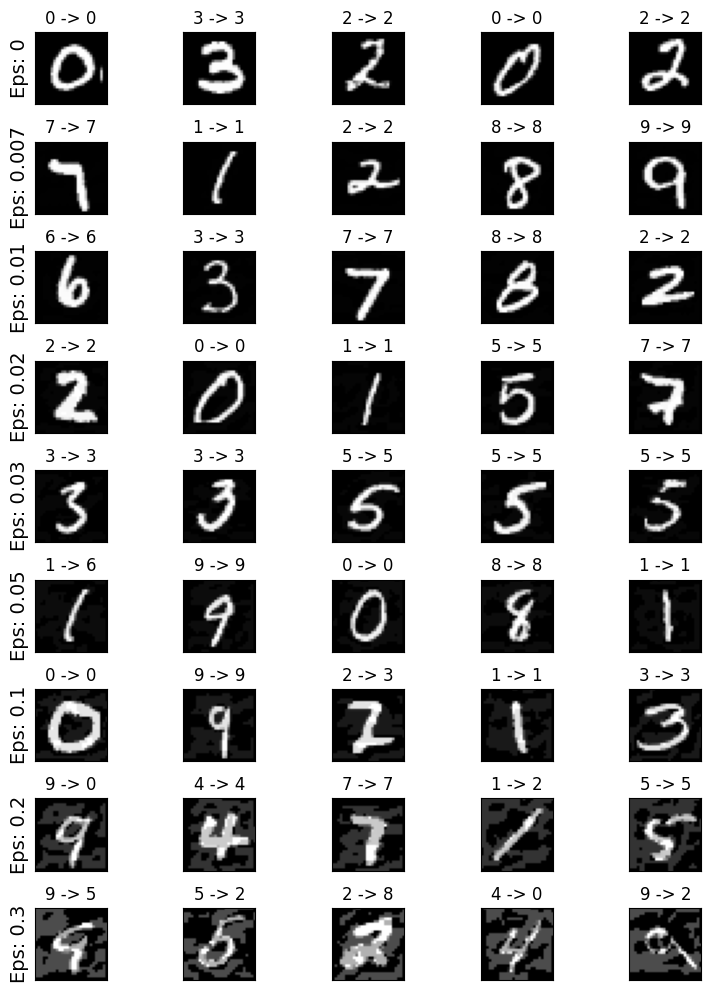

Epsilon: 0	Test Accuracy = 8913 / 10000 = 0.8913
Epsilon: 0.007	Test Accuracy = 8838 / 10000 = 0.8838
Epsilon: 0.01	Test Accuracy = 8846 / 10000 = 0.8846
Epsilon: 0.02	Test Accuracy = 8743 / 10000 = 0.8743
Epsilon: 0.03	Test Accuracy = 8620 / 10000 = 0.862
Epsilon: 0.05	Test Accuracy = 8342 / 10000 = 0.8342
Epsilon: 0.1	Test Accuracy = 7422 / 10000 = 0.7422
Epsilon: 0.2	Test Accuracy = 4057 / 10000 = 0.4057
Epsilon: 0.3	Test Accuracy = 1427 / 10000 = 0.1427


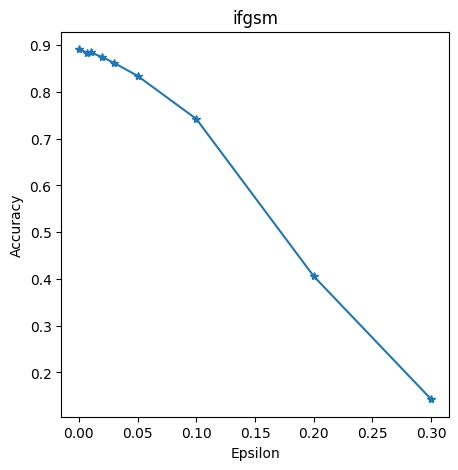

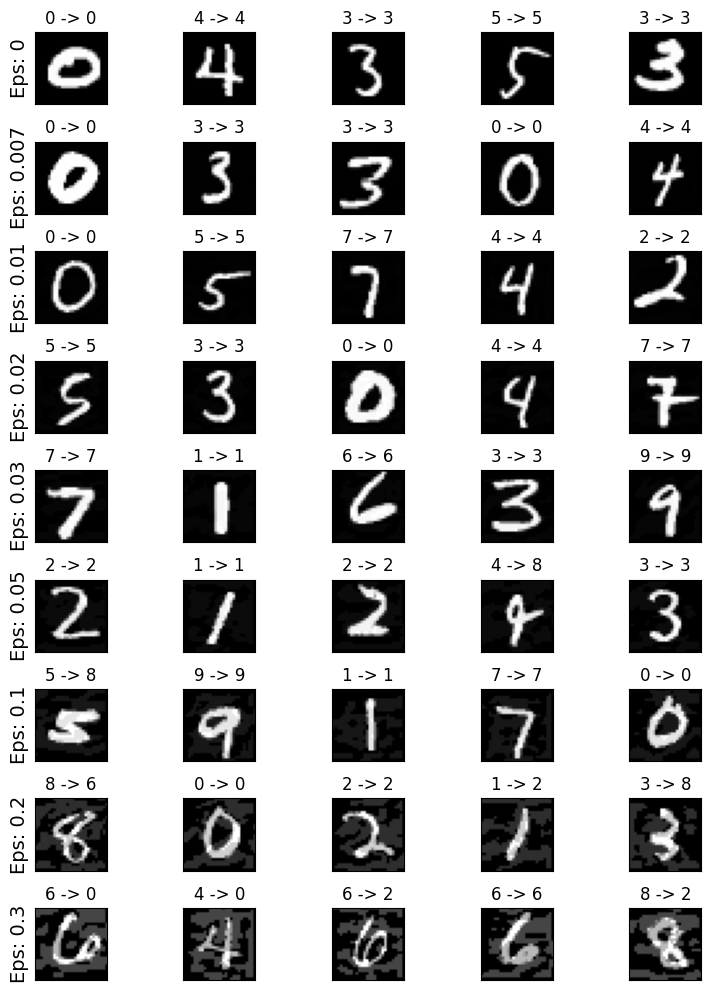

Epsilon: 0	Test Accuracy = 8902 / 10000 = 0.8902
Epsilon: 0.007	Test Accuracy = 8851 / 10000 = 0.8851
Epsilon: 0.01	Test Accuracy = 8791 / 10000 = 0.8791
Epsilon: 0.02	Test Accuracy = 8736 / 10000 = 0.8736
Epsilon: 0.03	Test Accuracy = 8614 / 10000 = 0.8614
Epsilon: 0.05	Test Accuracy = 8342 / 10000 = 0.8342
Epsilon: 0.1	Test Accuracy = 7504 / 10000 = 0.7504
Epsilon: 0.2	Test Accuracy = 4087 / 10000 = 0.4087
Epsilon: 0.3	Test Accuracy = 1434 / 10000 = 0.1434


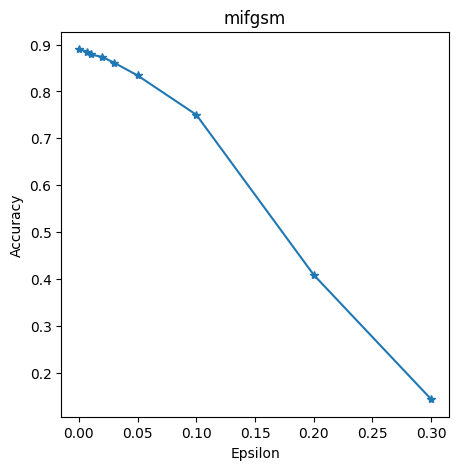

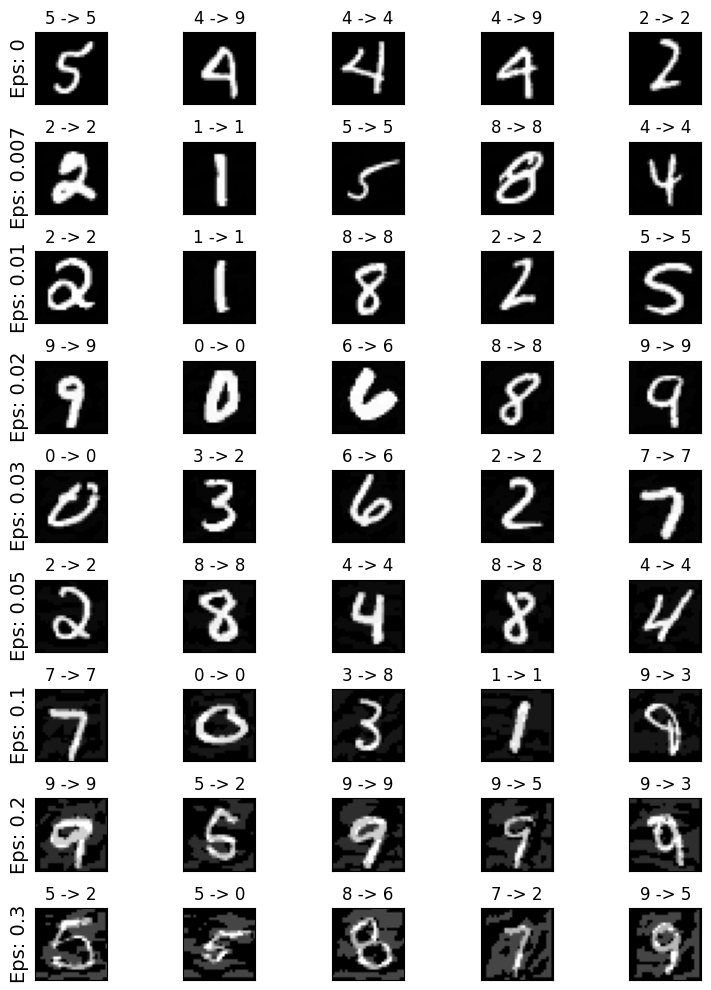

In [15]:
#Оценка защищенных сетей
Temp=100
epochs=10
epsilons=[0,0.007,0.01,0.02,0.03,0.05,0.1,0.2,0.3]
defense(device,train_loader,val_loader,test_loader,epochs,Temp,epsilons)